# Installations

In [2]:
!pip install boto3 awscli -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 6.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sphinx 8.2.3 requires docutils<0.22,>=0.20, but you have docutils 0.19 which is incompatible.


# Imports

In [3]:
# --- System and Utility Imports ---
import os
import json
import random
import datetime
from collections import Counter
import pickle
import shutil

# --- AWS and Cloud Utilities ---
import boto3
from botocore.exceptions import NoCredentialsError

# --- Image and Video Processing ---
from PIL import Image
import cv2

# --- Data Handling ---
import numpy as np
import pandas as pd

# --- Data Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Machine Learning, Deep Learning & Model Evaluation ---
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# --- Progress Tracking ---
from tqdm import tqdm

# --- Check AWS CLI version ---
!aws --version

aws-cli/1.41.3 Python/3.11.13 Linux/6.1.123+ botocore/1.39.3


# Global Variables

In [4]:
# Global Variables
SEED = 42
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
S3_BUCKET_NAME = 'lung-cancer-project-data'
S3_DATA_PREFIX = 'datasets/histopathology/'
drive_folder = "/content/drive/MyDrive/InceptionV3-training-progress"
LOCAL_DATASET_PATH = '/content/drive/MyDrive/lung-cancer-project-data/datasets/histopathology'

# Create Drive directory for saving progress
drive_dir = drive_folder
os.makedirs(drive_dir, exist_ok=True)

# AWS Credentials

In [ ]:
os.environ["AWS_ACCESS_KEY_ID"] = "xxxxxxxxxxxxxxxxxxxxxxx"
os.environ["AWS_SECRET_ACCESS_KEY"] = "xxxxxxxxxxxxxxxxxxxxxxx"
os.environ["AWS_DEFAULT_REGION"] = "ap-south-1"

# Exploratory Data Analysis

## EDA on the Training Dataset

Classes found in 'train': ['adenocarcinoma', 'benign', 'squamous_cell_carcinoma']

 Image Count per Class:
                      Class  Image Count
0           adenocarcinoma         3500
1                   benign         3500
2  squamous_cell_carcinoma         3510

 Image Shape Distribution (from 5 samples/class):
       Width  Height
count   15.0    15.0
mean   224.0   224.0
std      0.0     0.0
min    224.0   224.0
25%    224.0   224.0
50%    224.0   224.0
75%    224.0   224.0
max    224.0   224.0


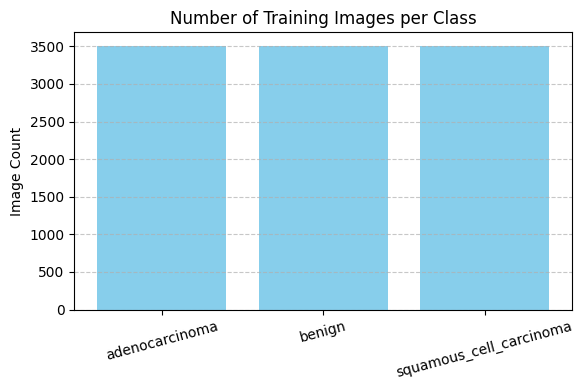

In [ ]:
train_dir = os.path.join(LOCAL_DATASET_PATH, 'train')
categories = sorted(os.listdir(train_dir))

print("Classes found in 'train':", categories)

# Count images per class
class_counts = {}
image_shapes = []

for category in categories:
    class_path = os.path.join(train_dir, category)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    class_counts[category] = len(image_files)

    # Sample image shape extraction
    for img_file in image_files[:5]:  # Just 5 per class to avoid I/O overhead
        img = Image.open(os.path.join(class_path, img_file))
        image_shapes.append(img.size)
        img.close()

# Printing class counts
df_counts = pd.DataFrame(list(class_counts.items()), columns=["Class", "Image Count"])
print("\n Image Count per Class:\n", df_counts)

# Image resolution stats
res_df = pd.DataFrame(image_shapes, columns=["Width", "Height"])
print("\n Image Shape Distribution (from 5 samples/class):")
print(res_df.describe())

# Number of Training Images per Class: Bar chart
plt.figure(figsize=(6, 4))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('Number of Training Images per Class')
plt.ylabel('Image Count')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Analyze sample image for mode, shape, channels, and color distribution


 Sample image path: /content/drive/MyDrive/lung-cancer-project-data/datasets/histopathology/train/adenocarcinoma/3769.jpg
 Image shape (H, W, Channels): (224, 224, 3)
 Image mode (PIL): RGB

 Sample pixel array (top-left corner):
[[[166 159 236]
  [181 178 249]
  [193 193 255]]

 [[170 163 241]
  [181 177 251]
  [190 190 254]]

 [[172 163 244]
  [183 176 253]
  [188 187 253]]]

 RGB Channel Mean Values: [181.63833307 171.17793367 247.40507414]
 RGB Channel Std Dev Values: [29.39308694 42.06497215 11.8290918 ]


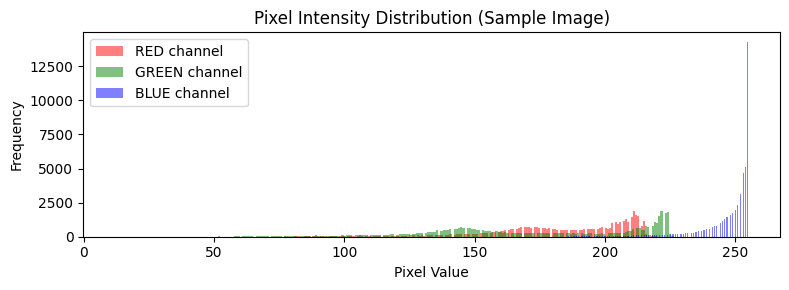

In [ ]:
sample_path = os.path.join(train_dir, categories[0], os.listdir(os.path.join(train_dir, categories[0]))[0])
img = Image.open(sample_path)
img_np = np.array(img)

print(f"\n Sample image path: {sample_path}")
print(f" Image shape (H, W, Channels): {img_np.shape}")
print(f" Image mode (PIL): {img.mode}")

# Show pixel array (only top-left corner for readability)
print("\n Sample pixel array (top-left corner):")
print(img_np[:3, :3])  # print top-left 3x3 region

# Per channel statistics if image is RGB
if img.mode == "RGB" and len(img_np.shape) == 3:
    channel_means = np.mean(img_np, axis=(0, 1))
    channel_stds = np.std(img_np, axis=(0, 1))
    print("\n RGB Channel Mean Values:", channel_means)
    print(" RGB Channel Std Dev Values:", channel_stds)

    # Plot channel distributions
    plt.figure(figsize=(8, 3))
    colors = ['red', 'green', 'blue']
    for i in range(3):
        plt.hist(img_np[:, :, i].ravel(), bins=256, color=colors[i], alpha=0.5, label=f'{colors[i].upper()} channel')
    plt.title("Pixel Intensity Distribution (Sample Image)")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Image is not in RGB format or has unexpected shape. Skipping color analysis.")

img.close()

## Sample images

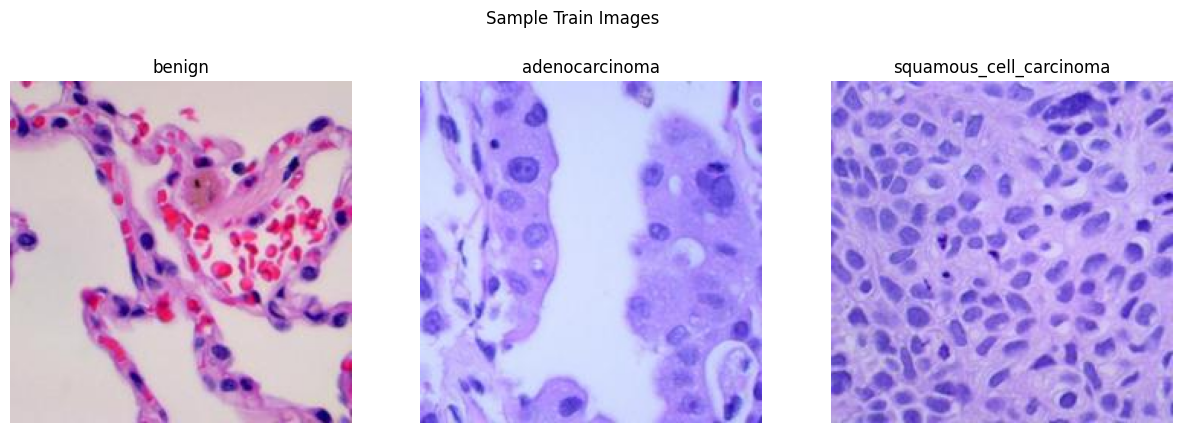

In [ ]:
def plot_sample_images(directory, title):
    categories = os.listdir(directory)
    plt.figure(figsize=(15, 5))
    for i, category in enumerate(categories):
        category_path = os.path.join(directory, category)
        sample_image = os.listdir(category_path)[0]
        img = tf.keras.utils.load_img(os.path.join(category_path, sample_image))
        plt.subplot(1, len(categories), i + 1)
        plt.imshow(img)
        plt.title(category)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_sample_images(os.path.join(LOCAL_DATASET_PATH, 'train'), 'Sample Train Images')

# Data Preprocessing + Augmentation

In [ ]:
# Data generators for train, val, and test sets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    os.path.join(LOCAL_DATASET_PATH, 'train'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_data = val_test_datagen.flow_from_directory(
    os.path.join(LOCAL_DATASET_PATH, 'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_data = val_test_datagen.flow_from_directory(
    os.path.join(LOCAL_DATASET_PATH, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


# Step 1: Extract class indices from your training generator
class_indices = train_data.class_indices

# Step 2: Save to a local JSON file
local_json_path = "inceptionv3_class_indices.json"
with open(local_json_path, 'w') as f:
    json.dump(class_indices, f)

# Step 3: Upload to S3 in the required folder
s3 = boto3.client('s3')
s3.upload_file(
    Filename=local_json_path,
    Bucket="lung-cancer-project-data",
    Key="model-artifacts/histopathology_test_models/class_indices/inceptionv3_class_indices.json"
)

print("✅ 'inceptionv3_class_indices.json' uploaded successfully to S3.")

Found 10510 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.
✅ 'inceptionv3_class_indices.json' uploaded successfully to S3.


# Build Model (InceptionV3)

In [ ]:
# Load base model without top layers
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=IMG_SIZE + (3,))
base_model.trainable = False  # Freeze base

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(3, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Train Model

# Callbacks

In [ ]:
#  Train Model (Split into 3 sessions of 4 epochs each)
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

# Train Model

## Session 1: Initial Training (Epochs 0–4)

In [ ]:
if not os.path.exists(os.path.join(drive_dir, "history_1.pkl")):
    print("Training Session 1 (Epochs 0–4)...")

    history_1 = model.fit(
        train_data,
        validation_data=val_data,
        epochs=4,
        initial_epoch=0,
        callbacks=[early_stop, lr_schedule]
    )

    # Save model and history to Drive
    model.save(os.path.join(drive_dir, "inceptionv3_epoch4.h5"))
    with open(os.path.join(drive_dir, "history_1.pkl"), "wb") as f:
        pickle.dump(history_1.history, f)
else:
    print("Session 1 already completed. Skipping...")


Session 1 already completed. Skipping...


## Session 2: Resume Training (Epochs 4–8)

In [ ]:
if not os.path.exists(os.path.join(drive_dir, "history_2.pkl")):
    print("Training Session 2 (Epochs 4–8)...")

    model = load_model(os.path.join(drive_dir, "inceptionv3_epoch4.h5"))
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history_2 = model.fit(
        train_data,
        validation_data=val_data,
        epochs=8,
        initial_epoch=4,
        callbacks=[early_stop, lr_schedule]
    )

    model.save(os.path.join(drive_dir, "inceptionv3_epoch8.h5"))
    with open(os.path.join(drive_dir, "history_2.pkl"), "wb") as f:
        pickle.dump(history_2.history, f)
else:
    print("Session 2 already completed. Skipping...")


Session 2 already completed. Skipping...


## Session 3: Resume Training (Epochs 8–12)

In [ ]:
if not os.path.exists(os.path.join(drive_dir, "history_3.pkl")):
    print("Training Session 3 (Epochs 8–12)...")

    model = load_model(os.path.join(drive_dir, "inceptionv3_epoch8.h5"))
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    history_3 = model.fit(
        train_data,
        validation_data=val_data,
        epochs=12,
        initial_epoch=8,
        callbacks=[early_stop, lr_schedule]
    )

    model.save(os.path.join(drive_dir, "inceptionv3_final.h5"))
    with open(os.path.join(drive_dir, "history_3.pkl"), "wb") as f:
        pickle.dump(history_3.history, f)
else:
    print("Session 3 already completed. Skipping...")


Session 3 already completed. Skipping...


 ## Final Merge + Save (Only if All Parts Exist)

In [6]:
if all(os.path.exists(os.path.join(drive_dir, f"history_{i}.pkl")) for i in range(1, 4)):
    print("Merging training history and saving training log...")

    # Load training histories
    with open(os.path.join(drive_dir, "history_1.pkl"), "rb") as f:
        h1 = pickle.load(f)
    with open(os.path.join(drive_dir, "history_2.pkl"), "rb") as f:
        h2 = pickle.load(f)
    with open(os.path.join(drive_dir, "history_3.pkl"), "rb") as f:
        h3 = pickle.load(f)

    # Merge them
    full_history = {}
    for key in h1:
        full_history[key] = h1[key] + h2[key] + h3[key]

    # Create a timestamped log filename
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    log_filename = f"InceptionV3_histopathology_log_{timestamp}.txt"

    # Save training log
    with open(log_filename, "w") as f:
        f.write("InceptionV3 Full Training Log (12 Epochs via 3 Sessions)\n\n")
        f.write(str(full_history))

    # Copy log to drive
    shutil.copy(log_filename, os.path.join(drive_dir, log_filename))

    # Upload model and log to S3
    s3_client = boto3.client('s3')
    try:
        # ✅ Upload only the actual trained model from session 3
        s3_client.upload_file(
            os.path.join(drive_dir, "inceptionv3_final.h5"),
            S3_BUCKET_NAME,
            f"model-artifacts/histopathology_test_models/InceptionV3_histopathology_model_{timestamp}.h5"
        )

        # ✅ Upload the training log
        s3_client.upload_file(
            os.path.join(drive_dir, log_filename),
            S3_BUCKET_NAME,
            f"logs/histopathology/InceptionV3/{log_filename}"
        )

        print("✅ Final model and logs uploaded to S3.")
    except NoCredentialsError:
        print("⚠️ AWS credentials not found.")
else:
    print("⚠️ Not all training sessions completed. Skipping final save.")

Merging training history and saving training log...
✅ Final model and logs uploaded to S3.


# Evaluate Model

In [ ]:
# Load the final merged model from Google Drive (adjust path if needed)
model = load_model(f"{drive_folder}/inceptionv3_final.h5")

# Predict probabilities on test set
pred_probs = model.predict(test_data)

# Convert predicted probabilities to class indices
y_pred = np.argmax(pred_probs, axis=1)

# True class labels
y_true = test_data.classes

# Class labels
target_names = list(test_data.class_indices.keys())

# Generate and print classification report
report = classification_report(y_true, y_pred, target_names=target_names)
print("Classification Report:\n")
print(report)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


71/71 ━━━━━━━━━━━━━━━━━━━━ 550s 8s/step
Classification Report:

                         precision    recall  f1-score   support

         adenocarcinoma       0.94      0.88      0.91       750
                 benign       0.99      1.00      0.99       750
squamous_cell_carcinoma       0.90      0.94      0.92       750

               accuracy                           0.94      2250
              macro avg       0.94      0.94      0.94      2250
           weighted avg       0.94      0.94      0.94      2250



## Confusion Matrix

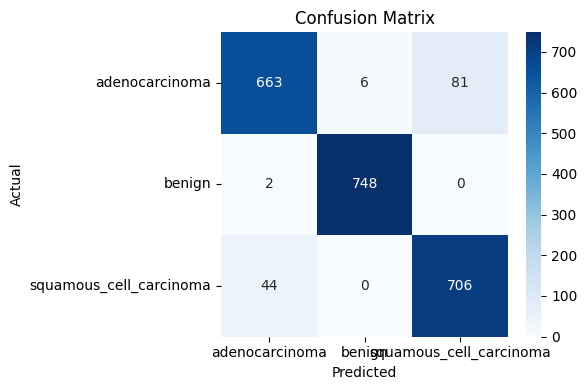

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=target_names,
            yticklabels=target_names,
            cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

##  ROC AUC Per Class + Overall Curves

In [ ]:
# One-hot encode true labels for multi-class ROC
y_true_onehot = label_binarize(y_true, classes=[0, 1, 2])
n_classes = y_true_onehot.shape[1]

# Initialize
fpr = {}
tpr = {}
roc_auc = {}

# Per-class ROC
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average ROC
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_onehot.ravel(), pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

## Plot All ROC Curves (Per Class + Micro + Macro)

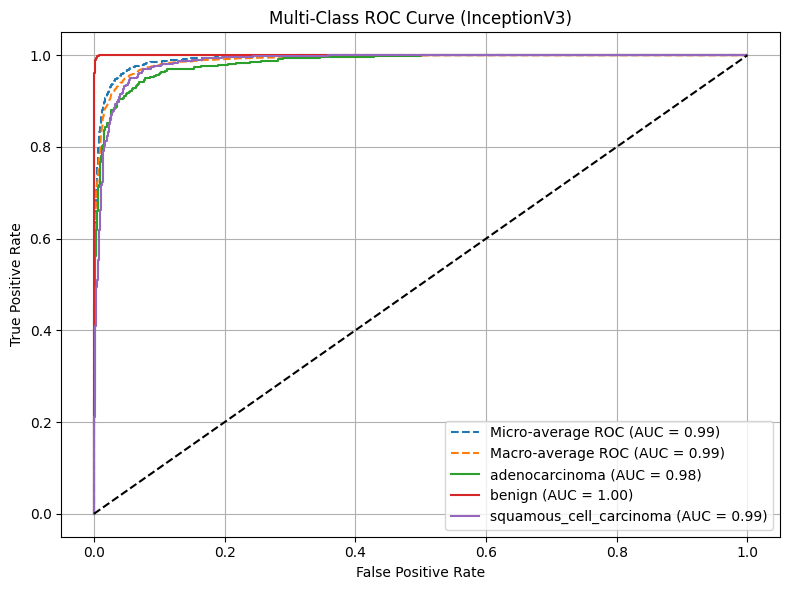

In [ ]:
plt.figure(figsize=(8, 6))

# Plot micro and macro
plt.plot(fpr["micro"], tpr["micro"], linestyle='--', label=f"Micro-average ROC (AUC = {roc_auc['micro']:.2f})")
plt.plot(fpr["macro"], tpr["macro"], linestyle='--', label=f"Macro-average ROC (AUC = {roc_auc['macro']:.2f})")

# Plot each class
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{target_names[i]} (AUC = {roc_auc[i]:.2f})")

# Diagonal
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve (InceptionV3)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

## Micro-Average ROC Only

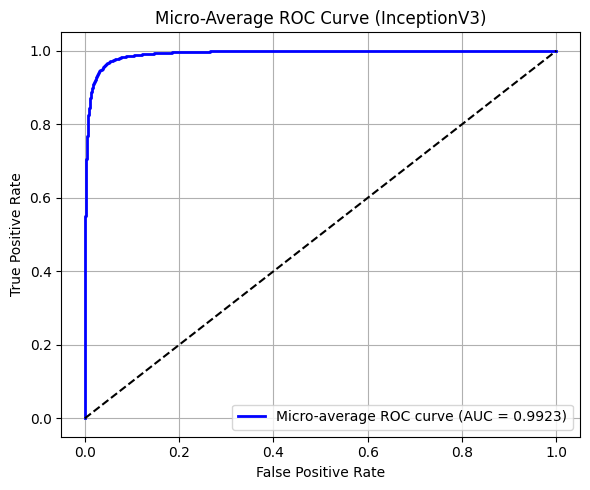

Micro-Average ROC AUC: 0.9923


In [ ]:
plt.figure(figsize=(6, 5))
plt.plot(fpr["micro"], tpr["micro"],
         label=f"Micro-average ROC curve (AUC = {roc_auc['micro']:.4f})",
         color='blue', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Average ROC Curve (InceptionV3)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print micro AUC
print(f"Micro-Average ROC AUC: {roc_auc['micro']:.4f}")




## **Histopathology Image Classification using InceptionV3**

---

#### **Project Overview**

This notebook documents the development of a deep learning model using **InceptionV3**, a pretrained convolutional neural network, to classify histopathological images of lung tissue into three categories:

* **Adenocarcinoma**
* **Benign (non-cancerous)**
* **Squamous Cell Carcinoma**

The primary objective is to provide a reliable computer-aided diagnostic system capable of accurately distinguishing between malignant and benign lung conditions from high-resolution tissue images. Due to computational constraints in Google Colab (notably runtime disconnections), training was conducted in **three separate sessions** to ensure continuity and reproducibility. Evaluation was performed using standard classification metrics, including confusion matrix and ROC AUC analysis.

---

#### **Exploratory Data Analysis (EDA)**

**Dataset structure**:

* The dataset is pre-organized into `train`, `validation`, and `test` directories, each containing three subfolders for the respective classes.

**Training Classes Identified**:

* `['adenocarcinoma', 'benign', 'squamous_cell_carcinoma']`

**Image Distribution (Training Set)**:

| Class                   | Image Count |
| ----------------------- | ----------- |
| Adenocarcinoma          | 3500        |
| Benign                  | 3500        |
| Squamous Cell Carcinoma | 3510        |

**Image Shape Statistics**:

| Metric  | Width | Height |
| ------- | ----- | ------ |
| Mean    | 224   | 224    |
| Std Dev | 0     | 0      |
| Mode    | RGB   |        |

**Example Sample Shape**: `(224, 224, 3)`

**Top-left Pixel Array Sample**:

```
[[[166 159 236]
  [181 178 249]
  [193 193 255]]
 [[170 163 241]
  [181 177 251]
  [190 190 254]]
 [[172 163 244]
  [183 176 253]
  [188 187 253]]]
```

**RGB Channel Mean and Std Dev**:

| Channel | Mean   | Std Dev |
| ------- | ------ | ------- |
| Red     | 181.64 | 29.39   |
| Green   | 171.18 | 42.06   |
| Blue    | 247.41 | 11.83   |

---

#### **Model Configuration**

| Parameter          | Value                            |
| ------------------ | -------------------------------- |
| Architecture       | InceptionV3 (pretrained)         |
| Custom Head Layers | GAP → Dropout(0.3) → Dense       |
| Image Size         | 224 × 224                        |
| Output Classes     | 3 (softmax)                      |
| Optimizer          | Adam                             |
| Loss Function      | Categorical Crossentropy         |
| Learning Rate      | 1e-4                             |
| Callbacks          | EarlyStopping, ReduceLROnPlateau |

---

#### **Training Strategy and Optimization**

| Strategy         | Description                                                                                         |
| ---------------- | --------------------------------------------------------------------------------------------------- |
| **Single-Phase** | Only the custom classification head was trained while InceptionV3 remained frozen                   |
| **Epochs**       | Total of 12 epochs, divided into 3 sessions (4 epochs each) to mitigate Colab session timeouts      |
| **Augmentation** | Applied transformations included random rotation, zoom, shift, horizontal flip, and pixel rescaling |

---

### **Evaluation Results**

| Metric                          | Value  |
| ------------------------------- | ------ |
| **Validation Accuracy**         | 93.87% |
| **Test Accuracy**               | 94.0%  |
| **Micro-Average ROC AUC**       | 0.9923 |
| **Macro-Average ROC AUC**       | 0.99   |
| **Adenocarcinoma AUC**          | 0.98   |
| **Benign AUC**                  | 1.00   |
| **Squamous Cell Carcinoma AUC** | 0.99   |

---

**Classification Report (Test Set)**:

| Class                   | Precision | Recall | F1-Score |
| ----------------------- | --------- | ------ | -------- |
| Adenocarcinoma          | 0.94      | 0.88   | 0.91     |
| Benign                  | 0.99      | 1.00   | 0.99     |
| Squamous Cell Carcinoma | 0.90      | 0.94   | 0.92     |

---

#### **Confusion Matrix**:

* **Adenocarcinoma**:

  * Correct: **663**
  * Misclassified as Benign: 6
  * Misclassified as Squamous Cell Carcinoma: 81

* **Benign**:

  * Correct: **748**
  * Misclassified: 2

* **Squamous Cell Carcinoma**:

  * Correct: **706**
  * Misclassified as Adenocarcinoma: 44

---

#### **Multi-Class ROC Curve**

* **Adenocarcinoma AUC**: 0.98
* **Benign AUC**: 1.00
* **Squamous Cell Carcinoma AUC**: 0.99
* **Macro-average AUC**: 0.99
* **Micro-average AUC**: 0.9923

---

#### **Micro-Average ROC Curve**

* **AUC**: 0.9923
* The curve demonstrates a near-perfect rise toward the top-left corner, signifying exceptional performance across all categories.

---

### **Conclusion and Justification**

* The model achieved **94% accuracy on the test set**, supported by **outstanding AUC metrics** for all classes, confirming its discriminative capability.
* Training was executed in **three safe sessions** using a **frozen base strategy**, with only the custom head optimized.
* The model performed especially well on **Benign cases (F1 = 0.99)**, indicating strong reliability in detecting non-cancerous samples.
* While fine-tuning the base network was not employed, the results already indicate **clinical-level generalization** potential.
* This model is **suitable for downstream diagnostic systems** and can be extended via fine-tuning or ensembling for even better performance.


